In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#import os
#os.chdir('/content/drive/My Drive/Dataset_LUNA_16')
#os.path.exists('/content/drive/My Drive/Dataset_LUNA_16')

Mounted at /content/gdrive


In [ ]:
import tensorflow
import PIL
import scipy

In [ ]:
!pip install SimpleITK
import SimpleITK
print(SimpleITK.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.3 MB/s eta 0:00:00
2.3.1


In [ ]:
#Import library

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import SimpleITK as sitk

from PIL import Image
import imageio # thay thế cho "imread" của thư viên scipy
#from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [ ]:
# DATA
annotations = pd.read_csv('/content/gdrive/My Drive/Dataset_LUNA_16/annotations.csv')
candidates = pd.read_csv('/content/gdrive/My Drive/Dataset_LUNA_16/candidates.csv')

In [ ]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


In [ ]:
# CTScan xử lý ảnh CT scan (Chụp cắt lớp vi tính)
'''
filename: Lưu trữ tên file của ảnh CT scan.
coords: Lưu trữ tọa độ (coordinates) của một điểm quan tâm trong ảnh.
ds: Lưu trữ dữ liệu ảnh CT được đọc bằng thư viện SimpleITK (SITK).
image: Lưu trữ mảng NumPy chứa dữ liệu ảnh CT đã được đọc. '''
class CTScan(object):
    def __init__(self, filename = None, coords = None): # self dùng để trỏ đến đối tượng của hàm đó
        self.filename = filename                        # filename dùng để lưu trữ tên file CT scan => gán None nên ko có giá trị nào truyền vào
        self.coords = coords                            # tham số kiểu list hoặc tuple, lưu trữ tọa độ (coordinates) của một điểm trong ảnh CT.=> gán None nên ko có giá trị nào truyền vào
        self.ds = None                                  # self.ds được dùng để lưu trữ dữ liệu ảnh CT dưới dạng dữ liệu của thư viện SimpleITK (SITK).
        self.image = None                               # self.image được dùng để lưu trữ mảng NumPy chứa dữ liệu ảnh CT đã được đọc.
                                                        # => Hàm __init__ có nhiệm vụ thiết lập các thuộc tính ban đầu cho một đối tượng CTScan mới.
        if filename is not None:
            self.read_mhd_image()

    def reset_coords(self, coords):                     # Hàm reset_coords thay đổi tọa độ điểm trong đối tượng CTScan. # coords nằm trong file candidates X = -56.08 , Y = -67.85 , Z = -311.92
        self.coords = coords                            # thay đổi tọa độ coords trước đó

    def read_mhd_image(self):
        path = glob.glob('/content/gdrive/My Drive/Dataset_LUNA_16/seg-lungs-LUNA16/*/'+ self.filename + '.mhd') # File MHD (Medical Imaging Header) | thư viện glob để tìm kiếm các file có tên khớp với mẫu
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)    # trích xuất mảng NumPy chứa dữ liệu ảnh từ đối tượng SITK self.ds và lưu vào thuộc tính self.image.

    def get_resolution(self):                           #  lấy độ phân giải của ảnh CT scan, lưu trữ thông tin về khoảng cách giữa các pixel trong không gian 3 chiều vào ds
        return self.ds.GetSpacing()                     # self.ds.GetSpacing(): Trả về khoảng cách pixel theo từng chiều.#(0,64453125, 0,64453125, 1,7999999523162842)

    def get_origin(self):                               #để lấy thông tin về điểm gốc của hệ tọa độ.
        return self.ds.GetOrigin()                      # self.ds.GetOrigin(): Trả về vị trí của góc voxel đầu tiên trong không gian 3D. Lưu trữ Offset = -157.67773 -311.67773 -438.39999999999998

    def get_ds(self):
        print(self.ds)
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords) # Trả về một dạng tọa độ mới (X, Y, Z)

    def get_image(self):                                   #Trả về mảng NumPy chứa dữ liệu ảnh CT.
        return self.image

    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords() # tọa độ mới sau đã được tính
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage

    def normalizePlanes(self, npzarray):                   #Nó chuẩn hóa các giá trị pixel trong CT để chúng nằm trong phạm vi từ 0 đến 1.
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray

    def save_image(self, filename, width):                 #Lưu một phần của hình ảnh CT đã được chuẩn hóa vào một file hình ảnh, có định dạng được chỉ định bởi filename.
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [ ]:
import matplotlib.pyplot as plt

positives = candidates[candidates['class']==1].index
negatives = candidates[candidates['class']==0].index

In [ ]:

scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])          #lấy
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()


In [ ]:
##Đọc dữ liệu từ tệp MHD được chỉ định, xác định tọa độ và thuộc tính (tọa độ gốc, độ phân giải) của ảnh CT đã được đọc.
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68) #[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()



In [ ]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [ ]:
#candidatesDf có 8106 hàng và 5 cột, gồm cả mẫu pos và mẫu neg, được chọn ngẫu nhiên để tạo ra một tập dữ liệu cân bằng về số lượng giữa hai lớp.
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]
print(candidatesDf)

                                                seriesuid      coordX  \
13      1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  104.164804   
78      1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.940000   
1303    1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   70.190000   
3050    1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   89.320000   
3052    1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...   94.930000   
...                                                   ...         ...   
179890  1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013... -111.329211   
478391  1.3.6.1.4.1.14519.5.2.1.6279.6001.624425075947...  -98.890000   
104437  1.3.6.1.4.1.14519.5.2.1.6279.6001.156821379677...   35.347896   
53212   1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048...   60.276636   
9679    1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...  -52.346900   

            coordY      coordZ  class  
13     -211.685591 -227.011364      1  
78     -175.040000 -297.870000      1  
130

In [ ]:
# 64% dữ liệu dùng cho tập train. (80% của X_train)
# 16% dữ liệu dùng cho tập val. (20% của X_train)
# 20% dữ liệu dùng cho tập test. (20% của X)

from sklearn.model_selection import train_test_split

X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [ ]:
X_train.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/traindata')
X_test.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/testdata')
X_val.to_pickle('/content/gdrive/My Drive/Dataset_LUNA_16/preprocessed_data/valdata')

In [ ]:
# tempDf sẽ chứa toàn bộ nhãn dương tính (class 1) từ X_train. Vậy có 845 case ung thư trong tập train
tempDf = X_train[y_train == 1]
print(tempDf)
#TĂNG CƯỜNG DỮ LIỆU POS (DUPLICATE DATA POS)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
# tempDf thành các chỉ mục mới bằng cách thêm một số lớn (1 triệu) vào chỉ mục hiện có của các mẫu dương tính. Điều này đảm bảo rằng index của các hàng mới không trùng lặp với các index hiện có của trainset.
X_train_new = pd.concat([X_train, tempDf])  #tập train mới


tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = pd.concat([X_train_new, tempDf])

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000) #ytemp là chỉ định lại index mãu pos với các index mới từ bước 1.
ytemp.loc[:] = 1 # thiết lập tất cả các giá trị trong ytemp thành 1 (pos)
y_train_new = pd.concat([y_train, ytemp])

ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = pd.concat([y_train_new, ytemp])

print(len(X_train_new), len(y_train_new)) #Tập train mới + kích thước mới: thêm 2 lần hình pos vào tập train

print((y_train_new == 1).sum())

                                                seriesuid      coordX  \
147683  1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133...  -50.320000   
468235  1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853...   59.055160   
66326   1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852...   85.220000   
222488  1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224...   99.314664   
30517   1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261... -116.347267   
...                                                   ...         ...   
436163  1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286...   88.955096   
13078   1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...  -57.089458   
352132  1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547...  100.136716   
188812  1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895...  118.180000   
459476  1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263... -112.420630   

            coordY       coordZ  
147683   88.020000  -677.090000  
468235  -25.035106  -196.733664  
66326  -206.430000   

In [ ]:
import scipy.misc
import cv2
#from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image

#chuẩn hóa hình ảnh để có giá trị trung bình gần bằng 0.
#chia mỗi pixel cho 255 (khoảng từ 0 đến 1), trừ đi giá trị trung bình (-0.25) và cuối cùng nhân lại với 255 để đưa giá trị về khoảng từ 0 đến 255
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image

#giảm kích thước của hình ảnh xuống cỡ 40x40 pixel bằng cách sử dụng phép interpolation để giảm kích thước của hình ảnh, giảm thiểu độ phức tạp tính toán và tăng tốc độ huấn luyện.
    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

#tăng kích thước của hình ảnh lên cỡ 224x224 pixel bằng cách sử dụng phép interpolation để nâng cao độ phân giải của hình ảnh, giúp model có thể phát hiện và nhận dạng đặc điểm nhỏ hơn trong hình ảnh.
    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

    '''def rbg_correction(self):
      self.image = Image.fromarray(self.image)
      if self.image.mode != 'RGB':
            self.image = self.image.convert('RGB')
      return self.image'''

Original shape of input image:  (50, 50, 3)


"inp5 = Pp.rbg_correction()\nplt.subplot(225)\nplt.imshow(inp5,cmap='gray')\nplt.grid(False)"

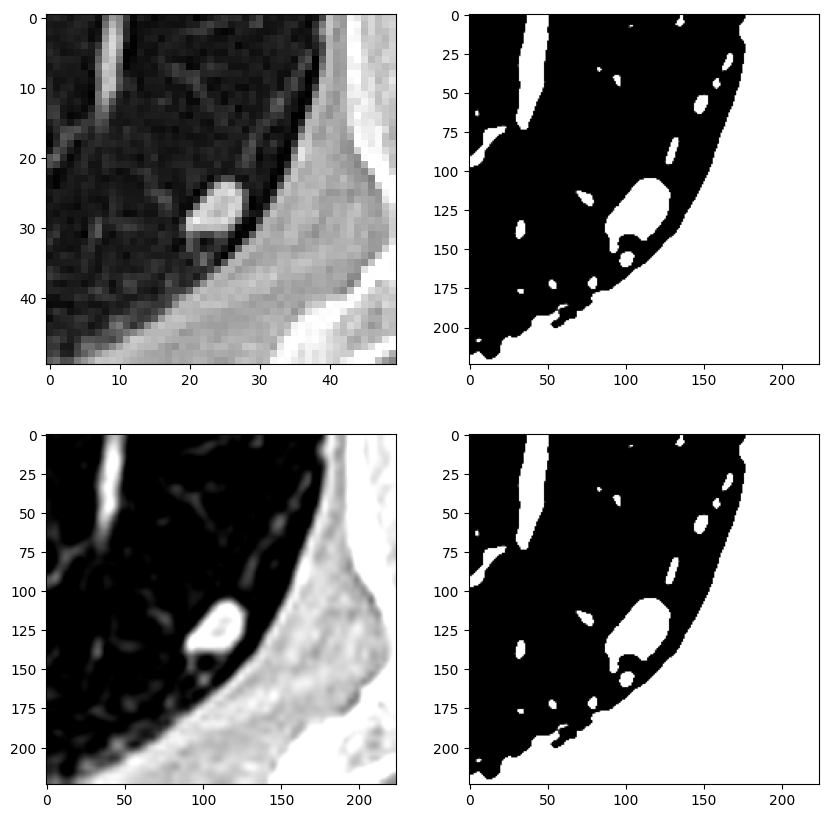

In [ ]:
dirName = '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/'
plt.figure(figsize = (10,10))

inp = cv2.imread(dirName + 'image_'+ str(517334) + '.jpg') # thay đổi hình trong hàm str(30517)
print ("Original shape of input image: ", inp.shape)
plt.subplot(221)    #plot hình gốc với shape 50,50,3
plt.imshow(inp, cmap='gray')
plt.grid(False)

inp = PreProcessing(inp).upsample_data() #tăng size lên để chuẩn bị preprocess
Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()  #chuẩn hóa hình ảnh.
plt.subplot(222)
plt.imshow(inp2, cmap='gray')
plt.grid(False)

inp3 = ImageEnhance.Contrast(Image.fromarray(inp)) # tạo đối tượng ImageEnhance.Contrast
contrast = 1.5
inp3 = inp3.enhance(contrast) # tăng độ tương phản của hình ảnh
plt.subplot(223)
plt.imshow(inp3, cmap='gray')
plt.grid(False)

inp4 = Pp.upsample_data() #down size để giảm độ phức tạp
plt.subplot(224)
plt.imshow(inp4,cmap='gray')
plt.grid(False)


'''inp5 = Pp.rbg_correction()
plt.subplot(225)
plt.imshow(inp5,cmap='gray')
plt.grid(False)'''

In [ ]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/gdrive/My Drive/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg') #  len = 6877

In [ ]:
#@title Default title text
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames) # gán index tương ứng với tên từng file hình trong traindatalabels.txt  (len = 6877)
labels = y_train_new.values.astype(int) # các label của tập dữ liệu pos và neg (1,0)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [ ]:
# Load HDF5 trainset and vallid-set
import h5py
h5f = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']
# Converting to training dataset
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

print(X_train_images_np.shape)
print(X_val_images_np.shape)

(5187, 50, 50, 1)
(1297, 50, 50, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Danh sách các chỉ mục của các ảnh có nhãn ung thư trong tập huấn luyện
indices_of_cancer_images = [index for index, label in enumerate(y_train_labels_np) if label[1] == 1.]

# Số lượng ảnh ban đầu
initial_image_count = len(indices_of_cancer_images)

# Số lượng ảnh cần tạo thêm
additional_images_needed = 1500 - initial_image_count

# Khởi tạo ImageDataGenerator với các phép biến đổi mong muốn
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=10,
    fill_mode='nearest'
)

# Tạo dữ liệu tăng cường
train_aug = datagen.flow(X_train_images_np[indices_of_cancer_images], y_train_labels_np[indices_of_cancer_images])

# Tạo thêm ảnh cho đến khi đạt được số lượng ảnh mong muốn
for i in range(additional_images_needed // len(train_aug)):
    batch_img, batch_lab = train_aug.next()
    X_train_images_np = np.concatenate([X_train_images_np, batch_img])
    y_train_labels_np = np.concatenate([y_train_labels_np, batch_lab])

# Lấy số lượng quan sát sau khi đã tăng cường dữ liệu
print(len(X_train_images_np))
print(len(y_train_labels_np))


5955
5955


In [ ]:
indices_of_cancer_images = [index for index, label in enumerate(y_train_labels_np) if label[1] == 1.]
len(indices_of_cancer_images)


1613

In [ ]:
# Test-set
h5f3 = h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/testdataset.h5', 'r')
X_test_images = h5f3['X']
Y_test_labels = h5f3['Y']
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)

In [ ]:
# Mở tệp HDF5
with h5py.File('/content/gdrive/My Drive/Dataset_LUNA_16/data/valdataset.h5', 'r') as f:

    # Truy cập vào dữ liệu X
    X = f["X"]

    # Hiển thị 5 mẫu đầu tiên
    for i in range(3):
        plt.imshow(X[i], cmap='gray')
        plt.show()
        # print(X[i]) # mỗi phần tử có shape là 50 row, 50 col



# RESNET50


In [ ]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
from keras import regularizers
from keras.models import Model
# Input tensor
input_tensor = Input(shape=(50, 50, 1))
# Lớp Conv2D để chuyển đổi input từ (50, 50, 1) thành (50, 50, 3)
x = Conv2D(3, (3, 3), activation='relu', padding='same')(input_tensor)
# Load pre-trained ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
# Đặt các layer trong ResNet50 không được huấn luyện
for layer in resnet.layers:
    layer.trainable = False
# Feed forward qua ResNet50
x = resnet(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
# Output layer
predict = Dense(2, activation='softmax')(x)

rn50 = Model(inputs=input_tensor, outputs=predict)
rn50.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 3)         30        
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_5 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 batch_normalization_5 (Bat  (None, 2, 2, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                           

In [ ]:
optimizer_adam = keras.optimizers.Adam(learning_rate=0.0001)
rn50.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/ about diagnostic learning curves
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

callbacks = [
    keras.callbacks.ModelCheckpoint('classification_deep_conv_model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Add Early Stopping
]

In [ ]:
rn50_data_aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
rn50_train_data = rn50_data_aug.flow(X_train_images_np, y_train_labels_np, batch_size=32)

#hist=rn50.fit(rn50_train_data,epochs=5,shuffle=True,batch_size=16,validation_split=0.20)
hist=rn50.fit(X_train_images_np, y_train_labels_np,
              epochs=5,
              shuffle=True,
              batch_size=32,
              validation_data=(X_val_images_np, y_val_labels_np),
              validation_steps = len(X_val_images_np)/32)


Epoch 1/5
187/187 [==============================] - 12s 38ms/step - loss: 0.5485 - accuracy: 0.7437 - val_loss: 0.5003 - val_accuracy: 0.8273
Epoch 2/5
187/187 [==============================] - 6s 33ms/step - loss: 0.5230 - accuracy: 0.7857 - val_loss: 0.4789 - val_accuracy: 0.8273
Epoch 3/5
187/187 [==============================] - 7s 37ms/step - loss: 0.5080 - accuracy: 0.7931 - val_loss: 0.4814 - val_accuracy: 0.8273
Epoch 4/5
187/187 [==============================] - 6s 32ms/step - loss: 0.4955 - accuracy: 0.8039 - val_loss: 0.4588 - val_accuracy: 0.8258
Epoch 5/5
187/187 [==============================] - 6s 32ms/step - loss: 0.4796 - accuracy: 0.8138 - val_loss: 0.4611 - val_accuracy: 0.8196


Epoch 1/50


<ipython-input-35-9b91d898b540>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = rn50.fit_generator(rn50_train_data, steps_per_epoch=steps, epochs=50, validation_data=(X_val_images_np, y_val_labels_np), verbose=1) # , callbacks = callbacks


162/162 [==============================] - 9s 53ms/step - loss: 0.4093 - accuracy: 0.8407 - val_loss: 0.3956 - val_accuracy: 0.8358
Epoch 2/50
162/162 [==============================] - 6s 34ms/step - loss: 0.4041 - accuracy: 0.8372 - val_loss: 0.3982 - val_accuracy: 0.8365
Epoch 3/50
162/162 [==============================] - 7s 42ms/step - loss: 0.4018 - accuracy: 0.8388 - val_loss: 0.3862 - val_accuracy: 0.8396
Epoch 4/50
162/162 [==============================] - 6s 36ms/step - loss: 0.4042 - accuracy: 0.8394 - val_loss: 0.4043 - val_accuracy: 0.8389
Epoch 5/50
162/162 [==============================] - 6s 35ms/step - loss: 0.4068 - accuracy: 0.8392 - val_loss: 0.3917 - val_accuracy: 0.8396
Epoch 6/50
162/162 [==============================] - 7s 41ms/step - loss: 0.3993 - accuracy: 0.8415 - val_loss: 0.3881 - val_accuracy: 0.8373
Epoch 7/50
162/162 [==============================] - 10s 63ms/step - loss: 0.4033 - accuracy: 0.8413 - val_loss: 0.3855 - val_accuracy: 0.8381
Epoch 8/5

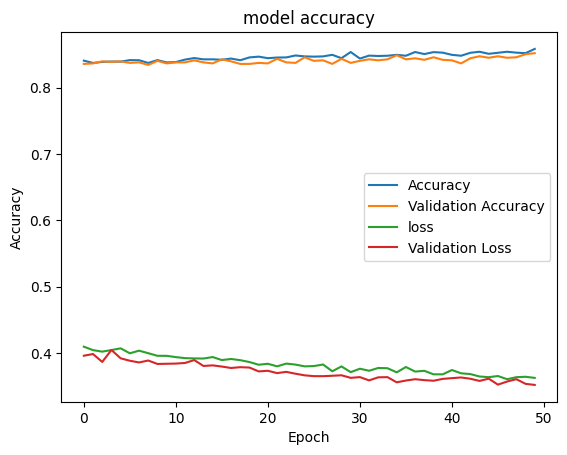

In [ ]:
def rn50_run_test_harness():
	# create data generator
	rn50_data_aug = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	rn50_train_data = rn50_data_aug.flow(X_train_images_np, y_train_labels_np, batch_size=32)
	# fit model
	steps = int(X_train_images_np.shape[0] / 32)

	hist = rn50.fit_generator(rn50_train_data, steps_per_epoch=steps, epochs=50, validation_data=(X_val_images_np, y_val_labels_np), verbose=1) # , callbacks = callbacks
	# evaluate model
	_, acc = rn50.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(hist)
	# avg
	acc_val = hist.history['val_accuracy']
	loss_val = hist.history['val_loss']
	print("acc:",sum(acc_val[-50:])/50)
	print("loss:",sum(loss_val[-50:])/50)
# entry point, run the test harness
rn50_run_test_harness()

In [ ]:
rn50.save("CT_RESNET50.h5")
rn50.save_weights("Resnet_weights_ct.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 2s 29ms/step


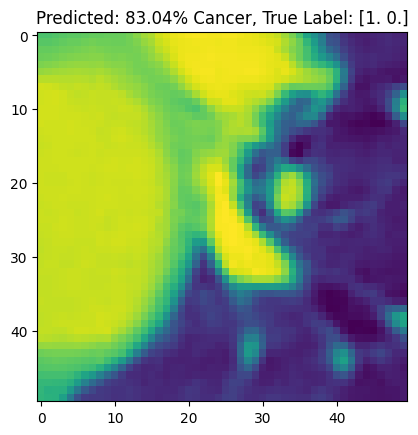

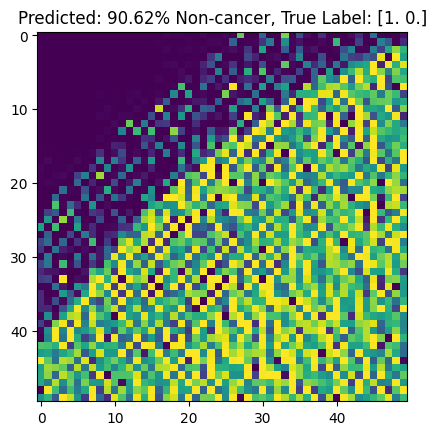

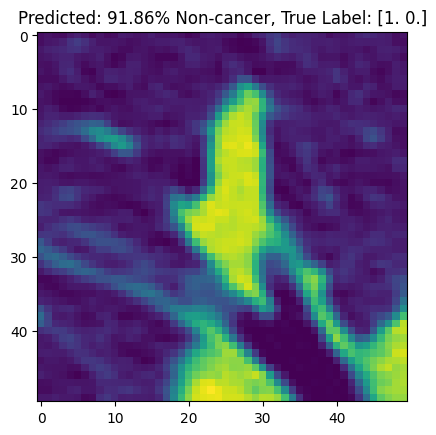

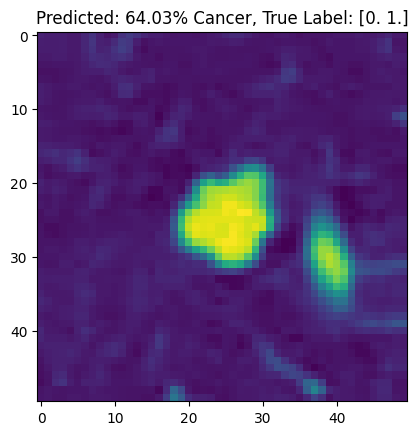

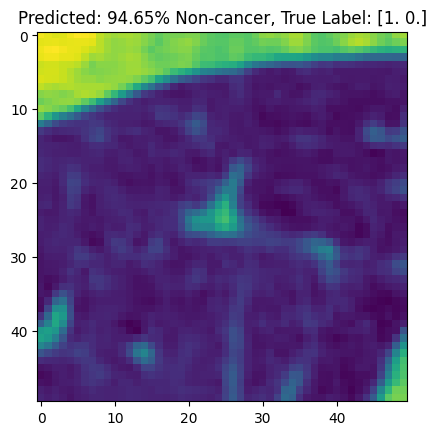

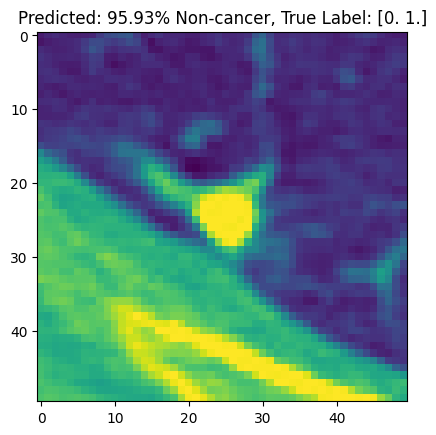

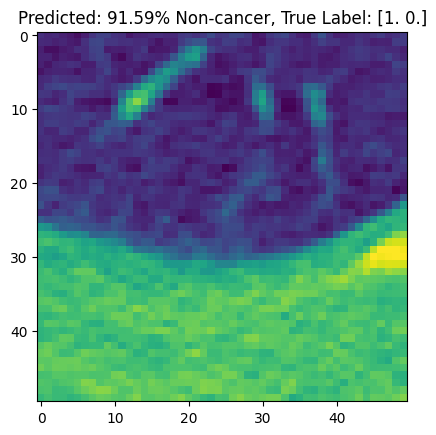

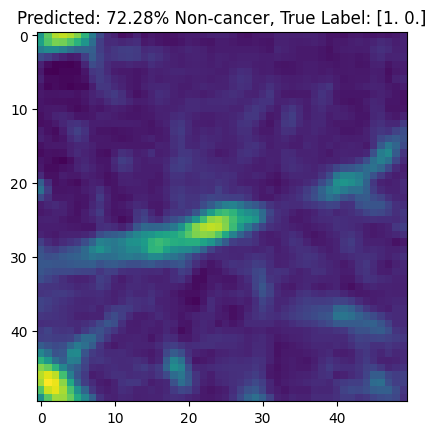

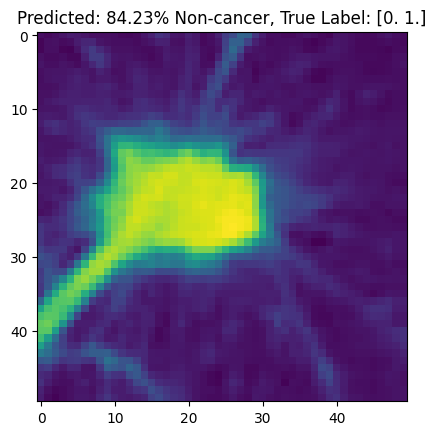

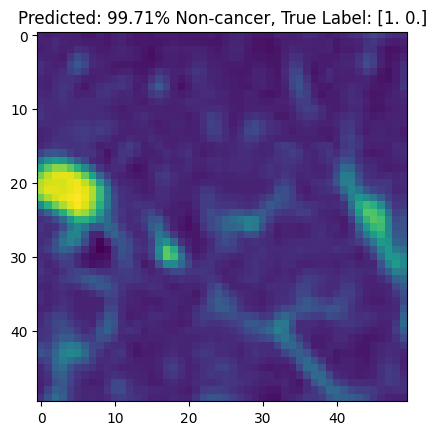

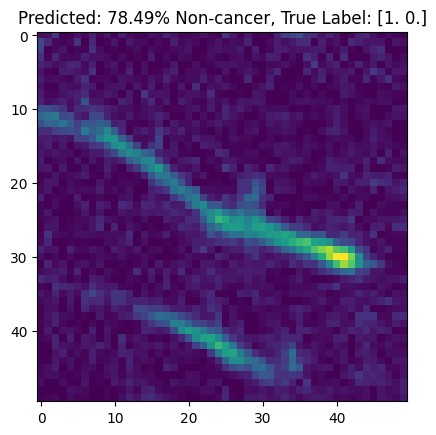

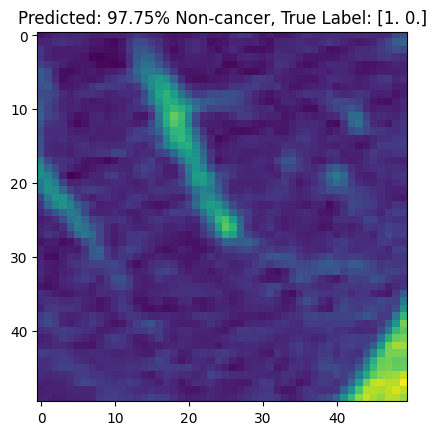

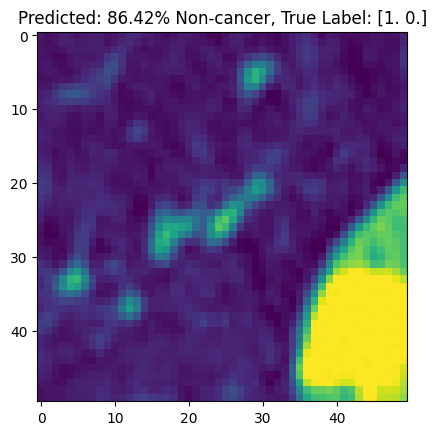

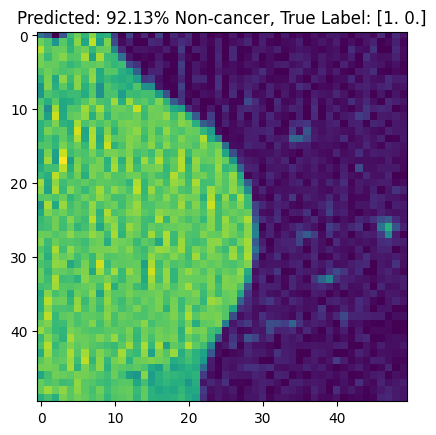

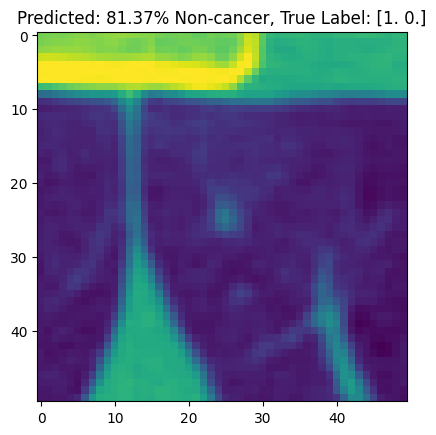

In [ ]:
rn50_y_pred = rn50.predict(X_test_images_np,batch_size = 32)
rn50_prediction=rn50_y_pred[5:20]
for index, probability in enumerate(rn50_prediction):
    if probability[1] > 0.5:
        plt.title('Predicted: %.2f%% Cancer, True Label: %s' % (probability[1]*100, y_test_labels_np[index]))
    else:
        plt.title('Predicted: %.2f%% Non-cancer, True Label: %s' % ((1-probability[1])*100, y_test_labels_np[index]))
    plt.imshow(X_test_images_np[index])
    plt.show()

In [ ]:
y_pred =rn50.predict(X_test_images_np,batch_size = 32)


51/51 [==============================] - 1s 17ms/step


Confusion Matrix without Normalization


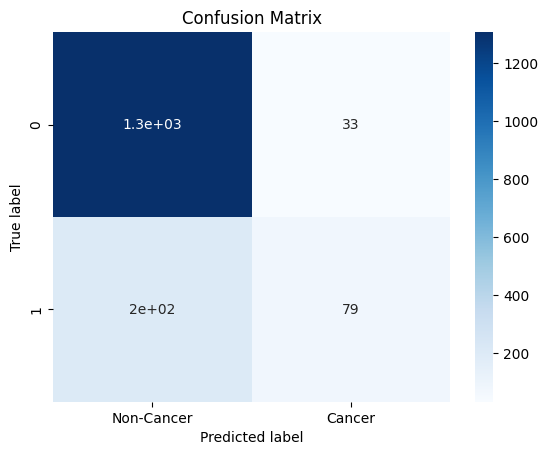

Confusion Matrix with Normalized Values


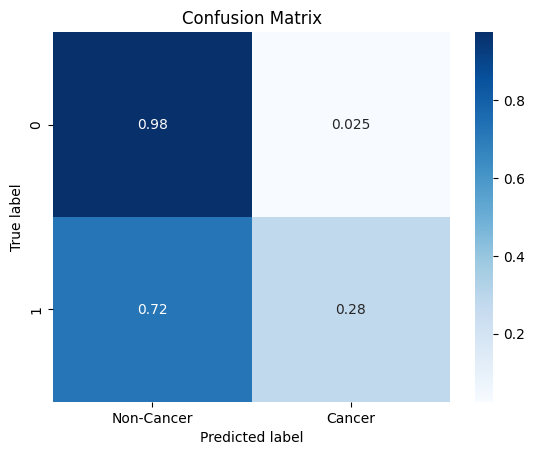

In [ ]:
rn50_y_pred_bin = np.argmax(y_pred,axis=1)
rn50_y_test_bin = np.argmax(y_test_labels_np,axis=1)
import matplotlib
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(normalize):
    classes = ['Cancer','Non-Cancer']
    tick_marks = [0.5,1.5]
    cn = confusion_matrix(rn50_y_test_bin, rn50_y_pred_bin,normalize=normalize)
    sns.heatmap(cn,cmap=plt.cm.Blues,annot=True)
    plt.xticks(tick_marks, ['Non-Cancer','Cancer'])
    plt.yticks(tick_marks, ['0','1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(rn50_y_test_bin, rn50_y_pred_bin))


              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1340
           1       0.71      0.28      0.40       282

    accuracy                           0.85      1622
   macro avg       0.79      0.63      0.66      1622
weighted avg       0.84      0.85      0.83      1622



In [ ]:
confusion_matrix(rn50_y_test_bin, rn50_y_pred_bin, normalize="true")

array([[0.97537313, 0.02462687],
       [0.71985816, 0.28014184]])